In [32]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
import pickle
from keras.regularizers import l2
from  scipy import ndimage

#### Dataset


Load dataset + One-hot encoding + Normalization

In [33]:
def load_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # One-hot encoding
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    # Normalize to [0,1]
    trainX = trainX.astype('float32') / 255.0
    testX = testX.astype('float32') / 255.0

    train_mean = trainX.mean((0,1,2))
    train_std = trainX.std((0,1,2))

    trainX = (trainX - train_mean) / train_std

    test_mean = testX.mean((0,1,2))
    test_std = testX.std((0,1,2))

    testX = (testX - test_mean) / test_std
    return trainX, trainY, testX, testY

#### Model

Imortant functions

In [34]:
def train(model, trainX, trainY, testX, testY):
	generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

	train_data = generator.flow(trainX, trainY, batch_size=64)

	results = model.fit(train_data, epochs=100, validation_data=(testX, testY), verbose=1)

	return results

def evaluate(model, testX, testY):
    _, acc = model.evaluate(testX, testY, verbose=0)

    print(f"The model achieved a final accuracy of {acc*100:.2f}%")

def plot_results(history):
	plt.title('Cross Entropy Loss')
	plt.plot(history['loss'], color='blue', label='Training loss')
	plt.plot(history['val_loss'], color='orange', label='Validation/test loss')
	plt.legend()
	plt.show()

	plt.title('Classification Accuracy')
	plt.plot(history['accuracy'], color='blue', label='Training accuracy')
	plt.plot(history['val_accuracy'], color='orange', label='Validation/test accuracy')
	plt.legend()
	plt.show()

In [35]:
def save_model(filename, model):
    filename = './models/' + filename
    pickle.dump(model, open(filename, 'wb'))

def save_history(filename, history):
    filename = './history/' + filename
    pickle.dump(history, open(filename, 'wb'))

def load_model(filename):
    filename = './models/' + filename
    model = pickle.load(open(filename, 'rb'))
    return model

def load_history(filename):
    filename = './history/' + filename
    history = pickle.load(open(filename, 'rb'))
    return history

Baseline model

In [36]:
def dropout_model():
    # Create architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Optimization method
    opt = SGD(learning_rate=0.01, momentum=0.9)

    # Compile model and choose loss type
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [37]:
trainX, trainY, testX, testY = load_dataset()

In [38]:
model = dropout_model()
results = train(model, trainX, trainY, testX, testY)

Epoch 1/100


2024-05-15 13:57:21.822238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 17s 19ms/step - loss: 1.6884 - accuracy: 0.3943 - val_loss: 1.2918 - val_accuracy: 0.5252
Epoch 2/100
782/782 [==============================] - 13s 17ms/step - loss: 1.3386 - accuracy: 0.5162 - val_loss: 1.1648 - val_accuracy: 0.5877
Epoch 3/100
782/782 [==============================] - 13s 17ms/step - loss: 1.1610 - accuracy: 0.5844 - val_loss: 1.0068 - val_accuracy: 0.6475
Epoch 4/100
782/782 [==============================] - 14s 17ms/step - loss: 1.0485 - accuracy: 0.6269 - val_loss: 0.8328 - val_accuracy: 0.7041
Epoch 5/100
782/782 [==============================] - 14s 17ms/step - loss: 0.9730 - accuracy: 0.6575 - val_loss: 0.8217 - val_accuracy: 0.7084
Epoch 6/100
782/782 [==============================] - 13s 17ms/step - loss: 0.9136 - accuracy: 0.6803 - val_loss: 0.7973 - val_accuracy: 0.7219
Epoch 7/100
782/782 [==============================] - 13s 17ms/step - loss: 0.8631 - accuracy: 0.6985 - val_loss: 0.7077 - val_accuracy: 0.74

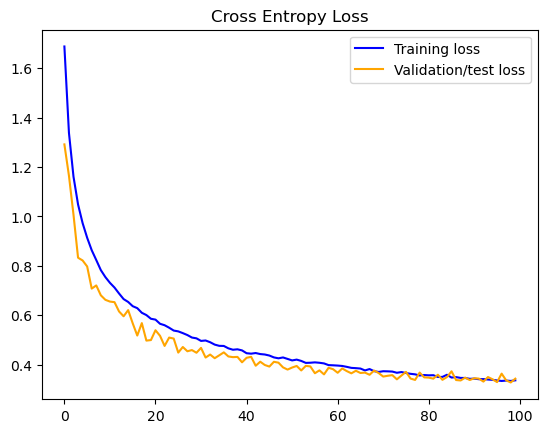

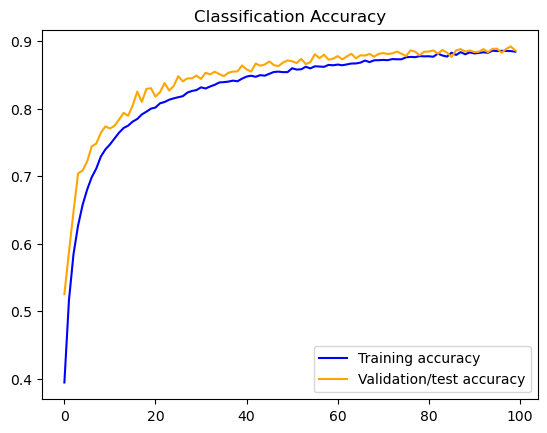

The model achieved a final accuracy of 88.64%


In [39]:
plot_results(results.history)
evaluate(model, testX, testY)

In [40]:
save_model('different_norm', model)
save_history('different_norm', results.history)

In [41]:
#from google.colab import files
#files.download('/content/models/dropout_augment_batch_model')
#files.download('/content/history/dropout_augment_batch_model')

In [42]:
test = load_model('different_norm')
history_test = load_history('different_norm')

FileNotFoundError: [Errno 2] No such file or directory: './models/dropout_augment_model'

In [ ]:
plot_results(history_test)
evaluate(test, testX, testY)